In [1]:
import huggingface_hub , os
from datasets import load_dataset
import torch
import pandas as pd
from sklearn.metrics import accuracy_score, auc, precision_score, recall_score, RocCurveDisplay
import sklearn.metrics as metrics
from transformers import AutoImageProcessor
from transformers import pipeline
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
num_patient = 5
num_obv =20

In [2]:
def tSNE_2D(X, y, random_state, perplexity, title ='t-SNE in 2D'): # Try different random_states/perplexities for a better view

    plt.close('all')
    X = preprocessing.MinMaxScaler().fit_transform(X) # Normalization
    
    
    X_tsne = TSNE(n_components=2,random_state=random_state, perplexity=perplexity).fit_transform(X) # Fit the 2D t-SNE
    plt.figure(figsize=(8, 8))
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y) # c=y means to colar the samples according to their label
    plt.title(title)
    plt.savefig(f"{title}.png", dpi=120)
    
    
def cal(X, y, angle, random_state, perplexity): 
    X = preprocessing.MinMaxScaler().fit_transform(X) # Normalization

    X_tsne = TSNE(n_components=3,random_state=random_state, perplexity=perplexity).fit_transform(X)
    return X_tsne

def tSNE_3D(X_tsne, y, angle1, angle2, title='t-SNE in 3D'): # Try different random_states/perplexities for a better view

    plt.close('all')

 # Fit the 3D t-SNE

    fig = plt.figure()

    # ax = fig.gca(projection='3d')

    ax = fig.add_subplot(projection = '3d')

    ax.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2], c=y) # c=y means to colar the samples according to their label

    plt.title(title)
    ax.view_init(angle1, angle2)  # Initialize the angle of 3D view
    plt.savefig(f"{title}.png", dpi=120)

In [3]:
from datasets import load_dataset

food = load_dataset("imagefolder", data_dir="kaggle-MSI", )

Resolving data files:   0%|          | 0/126100 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/31524 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/34688 [00:00<?, ?it/s]

In [4]:
df_val = pd.read_csv('List/Val_list_0_Mix').sort_values(['Y','Path']).reset_index(drop=True)
df_test = pd.read_csv('List/Test_list_Raw').sort_values(['Y','Path']).reset_index(drop=True)
df_train = pd.read_csv('List/Train_list_0_Mix').sort_values(['Y','Path']).reset_index(drop=True)

In [60]:
def sample_p(df, num_patient = num_patient, num_obv = num_obv):
    select_id = sorted(random.sample(df[df['Y']==0]['ID'].unique().tolist(), num_patient)) + sorted(random.sample(df[df['Y']==1]['ID'].unique().tolist(), num_patient))
    df = df[df['ID'].apply(lambda x: any(val in x for val in select_id))]
    df = df.groupby(["ID"]).sample(n=num_obv).sort_values(['Y','Path'])
    return df, select_id

In [84]:
df_sample, select_id = sample_p(df_train,num_patient,num_obv)
df_train_selected = df_train.loc[sorted(df_sample.index.to_list())]
df_val_selected = df_val[df_val['ID'].apply(lambda x: any(val in x for val in select_id))].groupby("ID").sample(n=int(num_obv/2), random_state=44)
label_encoder = LabelEncoder()
df_test_selected, testid = sample_p(df_test)
label_encoder.fit(select_id+testid)
df_test_selected['ID'] = label_encoder.transform(df_test_selected['ID'].values)
df_test_selected['Y'] = [2]*num_patient*num_obv+[3]*num_patient*num_obv
select_id = df_train_selected['ID'].values
df_train_selected['ID'] = label_encoder.fit_transform(select_id)
df_val_selected['ID'] = label_encoder.transform(df_val_selected['ID'].values)

In [7]:
classifier = pipeline("image-classification", model='/home/maggie1999424/Downloads/MSI2/msi-nat-mini/checkpoint-7882')


In [8]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer
model = AutoModelForImageClassification.from_pretrained(

    '/home/maggie1999424/Downloads/MSI2/msi-nat-mini/checkpoint-7882',
    num_labels=2,
    ignore_mismatched_sizes=True
)
model = model.eval()
def forward_features(self, pixel_values):
    outputs = self.nat(pixel_values)
    pooled_output = outputs[1]
    return pooled_output
model.forward_features = forward_features.__get__(model, type(model))
model = model.to('cuda:0')

In [9]:
image_train = food['train']['image']
image_val = food['validation']['image']
image_test = food['test']['image']


In [85]:
image_train_selected = [image_train[i] for i in df_train_selected.index.to_list()]
image_val_selected = [image_val[i] for i in df_val_selected.index.to_list()]
image_test_selected = [image_test[i] for i in df_test_selected.index.to_list()]

In [86]:
def get_score(mydict):
    score = []
    for i in mydict:
        for ii in i:
            # A = [0,0]
            if ii['label'] =='1':
                A = [1-ii['score'],ii['score']]
        score.append(A)
    return np.array(score)[:,1]

In [87]:
import torchvision
from  torchvision import transforms
from torch.utils.data import Dataset, DataLoader
def inf(image_selected):
    # Custom dataset class
    class CustomDataset(Dataset):
        def __init__(self, pil_list, transform=None):
            self.pil_list = pil_list
            self.transform = transform
        def __len__(self):
            return len(self.pil_list)
        def __getitem__(self, idx):
            img = self.pil_list[idx]
            img = self.transform(img)
            return img
        
    my_transforms = torchvision.transforms.Compose(
        [
            transforms.Resize((224, 224)), 
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.69261899, 0.51298305, 0.7263637], std=[0.13099993, 0.18332116, 0.14441279])])
    train_dataset = CustomDataset(image_selected, my_transforms)
    train_loader = DataLoader(train_dataset, num_obv, shuffle=False)
    train_score = []
    for i in train_loader:
        i = i.to('cuda:0')
        train_score.append(model.forward_features(i).detach().cpu().numpy() )
    train_score= np.array(train_score)
    train_score =train_score.reshape(len(train_dataset),512)
    return train_score

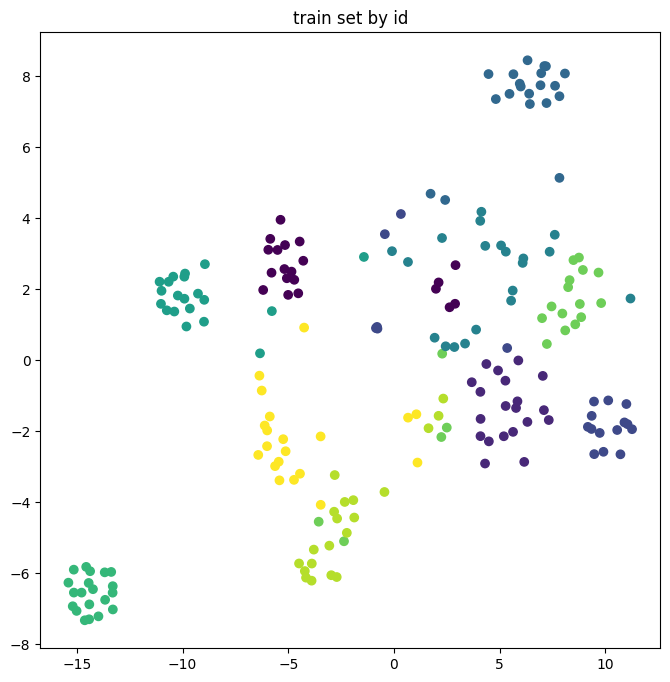

In [101]:
per = 35
random_state= 6
train_score = inf(image_train_selected)
tSNE_2D(train_score,df_train_selected['Y'].values, random_state=random_state,perplexity= per, title='train set by class')
tSNE_2D(train_score,df_train_selected['ID'].values, random_state=random_state,perplexity= per, title='train set by id')

In [102]:
val_score = inf(image_val_selected)

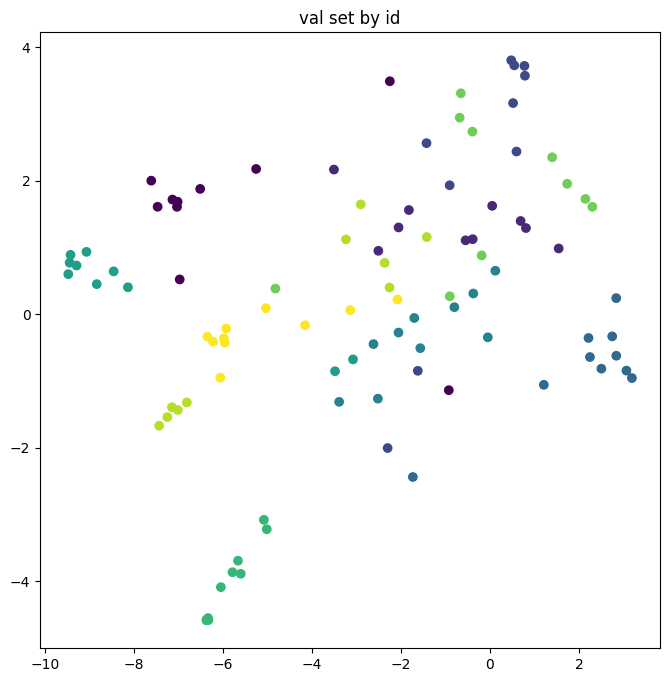

In [103]:
tSNE_2D(val_score,df_val_selected['Y'].values, random_state=random_state,perplexity= per, title='val set by class')
tSNE_2D(val_score,df_val_selected['ID'].values, random_state=random_state,perplexity= per, title='val set by id')


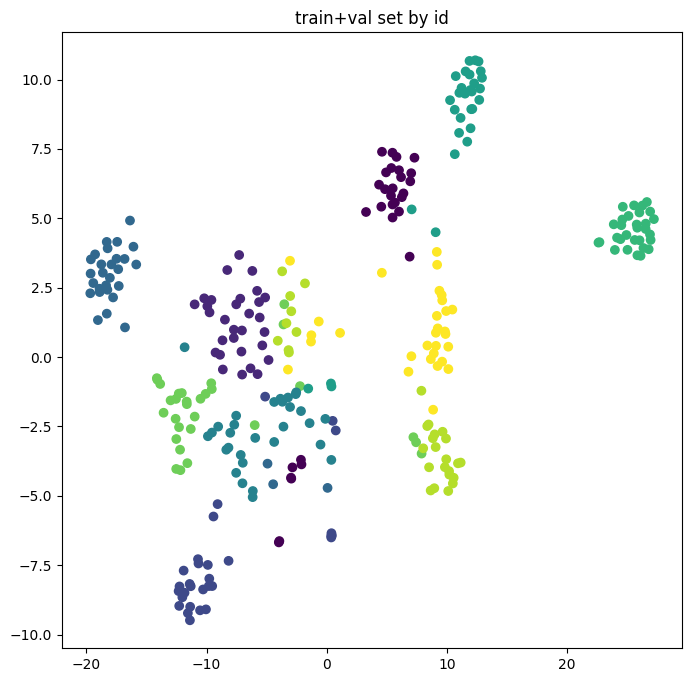

In [106]:
tSNE_2D(np.concatenate([train_score, val_score]),np.concatenate([df_train_selected['Y'].values, df_val_selected['Y'].values]), random_state=random_state,perplexity= per, title='train+val set by class')
tSNE_2D(np.concatenate([train_score, val_score]),np.concatenate([df_train_selected['ID'].values, df_val_selected['ID'].values]), random_state=random_state,perplexity= per, title='train+val set by id')

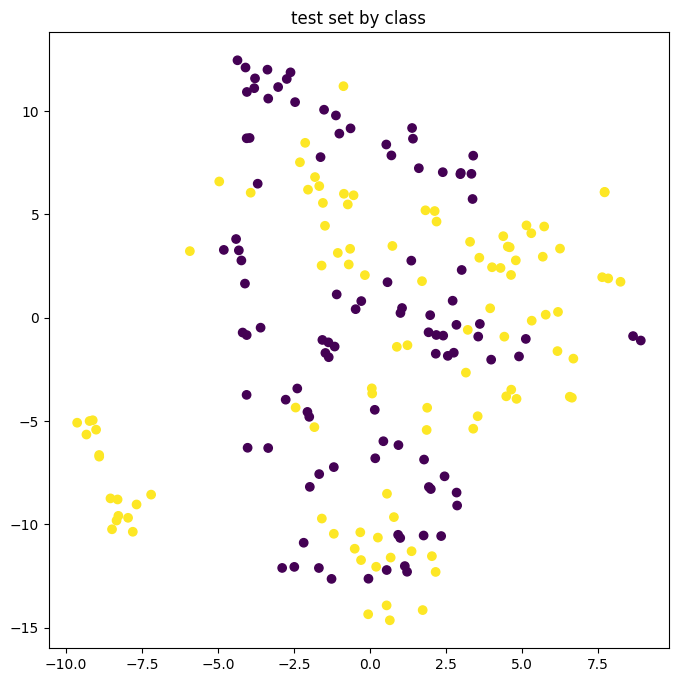

In [107]:
test_score = inf(image_test_selected)
tSNE_2D(test_score,df_test_selected['ID'].values, random_state=random_state,perplexity= per,  title='test set by id')
tSNE_2D(test_score,df_test_selected['Y'].values, random_state=random_state,perplexity= per, title='test set by class')


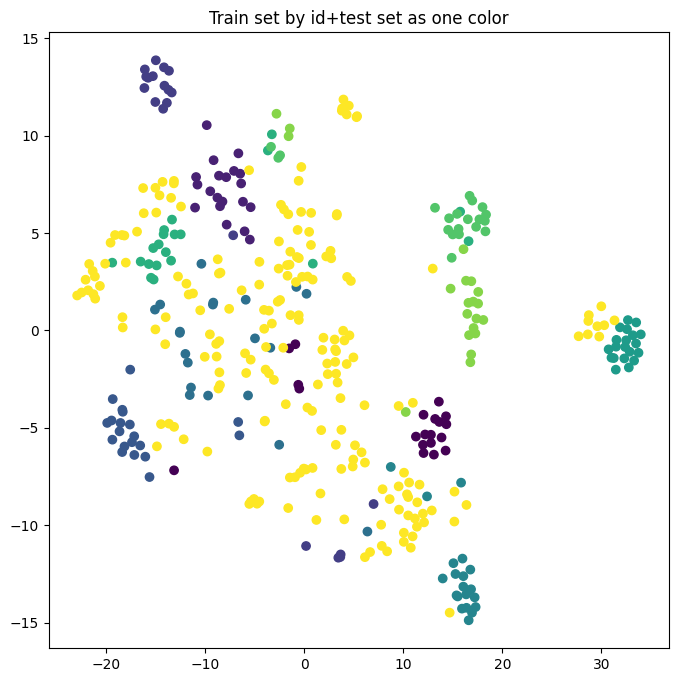

In [108]:
tSNE_2D(np.concatenate([train_score, test_score]),np.concatenate([df_train_selected['Y'].values, df_test_selected['Y'].values]), random_state=random_state,perplexity= per, title='Train+test set by class')
tSNE_2D(np.concatenate([train_score, test_score]),np.concatenate([df_train_selected['ID'].values, df_test_selected['ID'].values]), random_state=random_state,perplexity= per, title='Train+test set by id')
tSNE_2D(np.concatenate([train_score, test_score]),df_train_selected['ID'].values.tolist()+ [11]*len(df_test_selected), random_state=random_state,perplexity= per, title='Train set by id+test set as one color')

In [109]:
np.save('train_score.npy', train_score )
np.save('val_score.npy', val_score )
np.save('test_score.npy', test_score )
df_test_selected.to_csv('df_test_selected.csv',index = False)
df_val_selected.to_csv('df_val_selected.csv',index = False)
df_train_selected.to_csv('df_train_selected.csv',index = False)